In this homework you will make EN-RU translation system and look at the resulting quality :)


In [5]:
! pip install subword_nmt
! pip install gdown

In [6]:
import os

import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.datasets import TranslationDataset, Multi30k
from torchtext.legacy.data import Field, BucketIterator, TabularDataset
from nltk.tokenize import WordPunctTokenizer

from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

import random
import math
import time

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [7]:
path_to_data = './data.txt'
if not os.path.exists(path_to_data):
  ! wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1SP83UfArWIkOA1Biu0NXYs5qiLFGaHIZ' -O ./data.txt

--2021-10-17 18:22:20--  https://docs.google.com/uc?export=download&id=1SP83UfArWIkOA1Biu0NXYs5qiLFGaHIZ
Resolving docs.google.com (docs.google.com)... 142.250.148.138, 142.250.148.113, 142.250.148.102, ...
Connecting to docs.google.com (docs.google.com)|142.250.148.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-b0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/p1nfijutkp4go5jerdj4fvn2p6e5o91j/1634494875000/15658074880671286341/*/1SP83UfArWIkOA1Biu0NXYs5qiLFGaHIZ?e=download [following]
--2021-10-17 18:22:21--  https://doc-10-b0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/p1nfijutkp4go5jerdj4fvn2p6e5o91j/1634494875000/15658074880671286341/*/1SP83UfArWIkOA1Biu0NXYs5qiLFGaHIZ?e=download
Resolving doc-10-b0-docs.googleusercontent.com (doc-10-b0-docs.googleusercontent.com)... 173.194.194.132, 2607:f8b0:4001:c10::84
Connecting to doc-10-b0-docs.googleusercontent.com (doc-10

In [8]:
with open(path_to_data, 'r') as f:
  print(f.readlines()[:10])

['Cordelia Hotel is situated in Tbilisi, a 3-minute walk away from Saint Trinity Church.\tОтель Cordelia расположен в Тбилиси, в 3 минутах ходьбы от Свято-Троицкого собора.\n', 'At Tupirmarka Lodge you will find a 24-hour front desk, room service, and a snack bar.\tВ числе удобств лоджа Tupirmarka круглосуточная стойка регистрации и снэк-бар. Гости могут воспользоваться услугой доставки еды и напитков в номер.\n', 'Featuring free WiFi in all areas, Naigao Xiaowo offers accommodation in Shanghai.\tАпартаменты Naigao Xiaowo расположены в городе Шанхай. К услугам гостей бесплатный Wi-Fi во всех зонах.\n', 'Each has a TV and a private bathroom with shower.\tВ вашем распоряжении также телевизор и собственная ванная комната с душем.\n', 'Your room comes with air conditioning and satellite TV.\tНомер оснащен кондиционером и спутниковым телевидением.\n', 'They are styled in cream-coloured hues and some of them feature private balconies with seating areas.\tОни оформлены в кремовых тонах, в нек

First step - data preprocessing

In [9]:
!pip install subword-nmt

In [10]:
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

In [11]:
# Use BPE encoding (https://github.com/rsennrich/subword-nmt)
import io

# number of bpe codes
BPE_CODES = 6_000

# we work with data in a weird way, because this package work with files in FS (learn_bpe accept paths to files)
# we use io.StringIO to simulate FS save/load
with open(path_to_data, 'r') as fio:
    text = fio.read().split('\n')
    
    # in this example we create single tokenizer for eng/rus
    # you can split them if you need

    text_all = []
    for text_line in text:
        if len(text_line) > 1:
            en_ru = text_line.lower().split('\t')
            # add eng text to vocabulary
            text_all.append(en_ru[0])
            # add rus text
            text_all.append(en_ru[1])

# simulate FS files
with io.StringIO(''.join(text_all)) as input_f, \
    io.StringIO() as output_f:

    # train tokenizer
    learn_bpe(input_f, output_f, BPE_CODES)

    # initialize tokenizer
    tokenizer = BPE(output_f)

# again we create function tokenize, which is required for further data loading
def tokenize(x, tokenizer=tokenizer):
    return tokenizer.process_line(line = x)

In [12]:
tokenize('I like to eat cheese')
print(path_to_data)

./data.txt


In [13]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = TabularDataset(
    path = path_to_data,
    format = 'tsv',
    fields = [('trg', TRG), ('src', SRC)]
)

In [14]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [15]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [16]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [17]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 144
Unique tokens in target (en) vocabulary: 138


In [18]:
print(vars(train_data.examples[0]))

{'trg': 't@@ h@@ e private bathroom offers a walk@@ -@@ in shower@@ .', 'src': 'п@@ о@@ ми@@ мо этого, в распоряжении гостей собственная ванная комната с душе@@ м.'}


We will start from implementing basic LSTM

So, LSTM stands for Long-Short term memory and helps to reduce the problems with long sequences and vanishing gradients.

LSTM cell looks like this:

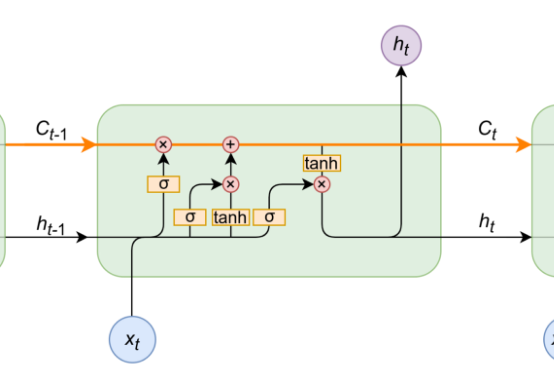

In other words we have:


*   Forget gate that helps to avoid storing not so importaint information
*   Input gate, where we decide what information should be stored in Long-Term memory
*   Output gate 







In [19]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        # There is a good option of embeddings creation which is nn.Embedding
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        # You can take nn.LSTM
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout) 
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, src):
        
        # Computes an embedding from the src data and apply dropout to it
        embedded = self.embedding(src)
        embedded = self.dropout(embedded)
      
        # embedded = [src sent len, batch size, emb dim]
        
        # Compute the RNN output values of the encoder RNN. 
        # outputs, hidden and cell should be initialized here. Refer to nn.LSTM docs ;)
        
        # <YOUR CODE HERE> 
        
        outputs, (hidden, cell) = self.rnn(embedded)

        #outputs =
        #outputs = [src sent len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell
    

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.out = nn.Linear(
            in_features=hid_dim,
            out_features=output_dim
        )
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        # Compute an embedding from the input data and apply dropout to it
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        # Compute the RNN output values of the encoder RNN. 
        # outputs, hidden and cell should be initialized here. Refer to nn.LSTM docs ;)
        
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.out(output.squeeze(0))
        
        #output = [sent len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #sent len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src sent len, batch size]
        #trg = [trg sent len, batch size]
        
        # Teacher forcing technique helps to make model generate longer sequences: when we just begin training
        # we give our model only ground truth tokens and when the model is more trained we start
        # to give the generated predictions as an input to model the inference situation

        # teacher_forcing_ratio is probability to use teacher forcing
        # e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        # Again, now batch is the first dimention instead of zero
        batch_size = trg.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, max_len):
            
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            input = (trg[t] if teacher_force else top1)
        
        return outputs

Batches preparation and model training

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [22]:
vars(valid_iterator.dataset.examples[0])

{'src': 'в распоряжении гостей помещения для проведения конференци@@ й, общий лаундж и игровая комната@@ .',
 'trg': 'o@@ ther facilities offered include meeting facilities, a shared lounge and a games room@@ .'}

In [23]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [24]:
def init_weights(m):
    # Now we should implement weights initialization - uniform from nn module will be ok
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(144, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(138, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=138, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 7,499,402 trainable parameters


In [26]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [27]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [28]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [29]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [40]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

In [41]:
# model = Seq2Seq(enc, dec, device).to(device)
# model.load_state_dict(torch.load('tut1-model_trained.pt', map_location="cuda:0"))  # Choose whatever GPU device number you want
# model.to(device)
# Make sure to call input = input.to(device) on any input tensors that you feed to the model

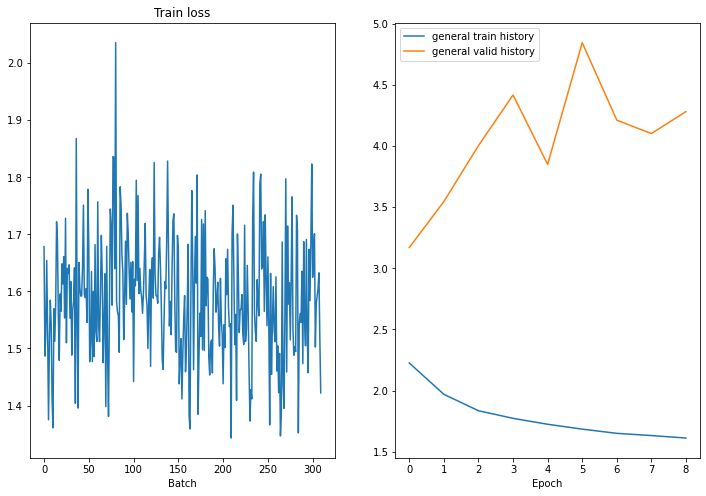

Epoch: 10 | Time: 11m 35s
	Train Loss: 1.588 | Train PPL:   4.892
	 Val. Loss: 4.325 |  Val. PPL:  75.588


In [42]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [43]:
from google.colab import files
files.download('tut1-model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [44]:
def get_text_from_output(x, TRG_vocab):
    text = [TRG_vocab.itos[token] for token in x]
    tokens_to_remove=['<eos>', '<sos>', '<unk>', '<pad>']
    try:
        end_idx = text.index('<eos>')
        text = text[:end_idx]
    except ValueError:
        pass
    text = [x for x in text if x not in tokens_to_remove]
    text = ' '.join(text).replace("@@ ", "").replace("@@", ""). replace("@", "")
    if len(text) < 1:
        text = []
    return text

In [45]:
from nltk.translate.bleu_score import corpus_bleu

def evaluate_bleu(model, iterator, TRG):
    orig_text = []
    gener_text = []

    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing
            output = output.argmax(dim=-1)
            
            gener_text.extend([get_text_from_output(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])
            orig_text.extend([get_text_from_output(x, TRG.vocab) for x in trg.cpu().numpy().T])            
            
    score = corpus_bleu([[text] for text in orig_text], gener_text) * 100
    return score

In [46]:
# Implement BLEU score calculation and get the corpora result
score = evaluate_bleu(model, valid_iterator, TRG)
print(score)

40.8227616085028


**(Optional part for additional points) Try different approaches for neural translation (for instance, add attention, use fine-tuning:)) and get >= 27 BLEU score.**

*Credits: Based on Harbour.Space University homework*
